In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import linear_model


import warnings
warnings.filterwarnings("ignore")

## Datos

In [2]:
df = pd.read_csv('Boston.csv')
df = df.drop(columns = ['Unnamed: 0'])
df= pd.get_dummies(df, columns=['rad'])
target = 'medv'
y = df[target]
X=df.copy()
X = X.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

## Modelo Red neuronal

In [3]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPRegressor())
])

params_grid = {
    'nn__hidden_layer_sizes': [(100,100,50), (100,100), (100,), (10,10)],
    'nn__activation': ['tanh', 'relu', 'logistic'],
    'nn__alpha': [0.1, 0.01]
}
# Fit 
grid_nn = GridSearchCV(estimator=pipeline, param_grid=params_grid, n_jobs=-1, cv=5, scoring='r2')
grid_nn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('nn', MLPRegressor())]),
             n_jobs=-1,
             param_grid={'nn__activation': ['tanh', 'relu', 'logistic'],
                         'nn__alpha': [0.1, 0.01],
                         'nn__hidden_layer_sizes': [(100, 100, 50), (100, 100),
                                                    (100,), (10, 10)]},
             scoring='r2')

In [4]:
grid_nn.best_params_

{'nn__activation': 'relu',
 'nn__alpha': 0.1,
 'nn__hidden_layer_sizes': (100, 100, 50)}

## R2 score

In [5]:
predicciones = grid_nn.best_estimator_.predict(X_test)
r2_score(y_pred=predicciones, y_true=y_test)

0.8568615723634435

## Calibración

In [6]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y':y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()
    
    plt.plot(grouped.predicciones, grouped.y, label='Modelo', marker = 'o')
    plt.plot(grouped.predicciones, grouped.predicciones, label='Real', marker = 'o')
    plt.grid()
    plt.legend()
    plt.xlabel('Prediccion')
    plt.ylabel('Real')

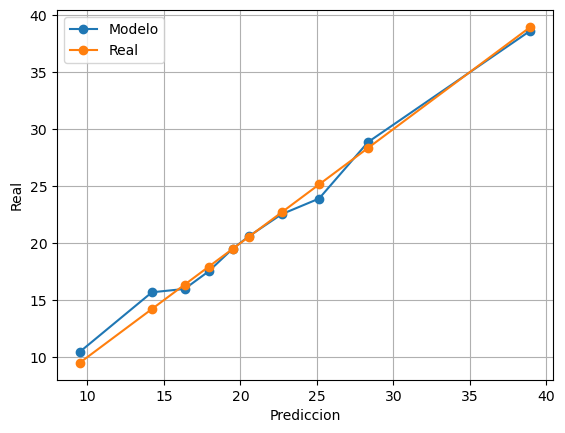

In [7]:
calibracion(predicciones, y_test, 10)

## Analisis

Tras haber hecho una red neuronal y con esta haber probado varias combinaciones con diferentes parametros utlizando Grid Search CV, obtuvimos que el mejor modelo que se podia ajustar a nuestros datos era aquel que tenia una función de activación Relu, con un alpha de 0.1 que es el que nos ayuda a penalizar aquellos coeficientes que esten muy altos, evitando tener overfitting junto con el cross validation y utlizando 3 capas ocultas, las primeras dos con 100 neuronas y la tercera con 50. 

Este modelo nos arrojó un R2 de 0.8568. Esto quiere decir que el modelo se ajusta a a un 85.68% de la variabilidad de los datos que se nos presentan. Este R2 es uno muy bueno, ya que se ajusta muy bien a los datos, justo como se ve en la gráfica, que si bien hay partes que se le dificulta ajustarse, hay unas donde se ajustan bien, indicandonos que tiene un buen nivel para poder hacer las predicciones. 